In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install nltk scikit-learn pandas transformers torch spacy

In [1]:
import os
import re
import pandas as pd
import numpy as np
import nltk
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from multiprocessing import Pool

In [2]:
def split_text_into_sections(text):
    """
    Splits a given text into predefined sections based on section titles.
    Returns dictionary with KEY as section title and VALUES as the content accumulated under each section.
    """
    sections = {
        "The complaint": "",
        "What happened": "",
        "What I’ve decided – and why": "",
        "My final decision": ""
    }

    current_section = None
    for line in text.split('\n'):
        line = line.strip()
        if not line:
            continue

        # Check if the line matches any section title
        if "The complaint" in line:
            current_section = "The complaint"
        elif "What happened" in line:
            current_section = "What happened"
        elif "What I’ve decided – and why" in line:
            current_section = "What I’ve decided – and why"
        elif "My final decision" in line:
            current_section = "My final decision"

        if current_section:
            sections[current_section] += line + " "

    return sections

In [3]:
from torch.utils.data import Dataset 
import torch

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

2024-08-09 00:34:50.720301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 00:34:50.720417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 00:34:50.892527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
class InsuranceDataset(Dataset):
    # Initializes the dataset with texts, labels, a tokenizer, and a maximum token length
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts) # The number of texts in the dataset

    # Retrieves the item at the specified index in the dataset and processes it for model input
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            max_length=self.max_length, # Truncate/pad to max_length
            return_token_type_ids=False, 
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            #'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
def create_labeled_dataset(txt_dir, annotations, label_map, max_length=512):
    '''
    Creates a labeled dataset by reading text files, extracting relevant sections,
    and associating them with labels based on provided annotations.
    '''
    texts = []
    labels = []
    
    # Iterate over each row in the annotations DataFrame
    for index, row in annotations.iterrows():
        file_name = row['file_name']
        label = row['The complaint_most_common_group_name']
        label_id = label_map[label]
        
        txt_file = os.path.join(txt_dir, file_name)
        with open(txt_file, "r", encoding="utf-8") as f:
            text = f.read()
        
        sections = split_text_into_sections(text) # Split the text into predefined sections
        the_complaint = sections.get("The complaint", "")
        what_happened = sections.get("What happened", "")[:200] # Limit this section to 200 characters
        combined_text = the_complaint + " " + what_happened
        
        texts.append(combined_text)
        labels.append(label_id)
    
    return InsuranceDataset(texts, labels, tokenizer, max_length)

In [7]:
def create_unlabeled_dataset(txt_dir, annotated_files, max_length=512):
    '''
    Creates a dataset of unlabeled texts by reading files that are not in the list of annotated files,
    extracting relevant text sections, and storing them.
    '''
    texts = []
    file_names = []
    for file_name in os.listdir(txt_dir):
        if file_name not in annotated_files and file_name.endswith(".txt"):
            txt_file = os.path.join(txt_dir, file_name)
            with open(txt_file, "r", encoding="utf-8") as f:
                text = f.read()
            
            sections = split_text_into_sections(text) # Split the text into predefined sections
            the_complaint = sections.get("The complaint", "")
            what_happened = sections.get("What happened", "")[:200]
            combined_text = the_complaint + " " + what_happened
            
            texts.append(combined_text)
            file_names.append(file_name)
    
    return list(zip(file_names, texts)) # Return a list of tuples pairing file names with their corresponding texts

In [8]:
# Load annotation data which includes labels assigned based on cosine similarity
annotations = pd.read_csv('/kaggle/input/results-1-6-all-label/results_1_6_all_cosin_label.csv')  
labels = list(set(annotations['The complaint_most_common_group_name'].values))
# Create a dictionary mapping each label to a unique integer index
label_map = {label: idx for idx, label in enumerate(labels)}

In [9]:
model_name = 'bert-base-uncased' # Loaded from Hugging Face transformers library
tokenizer = BertTokenizer.from_pretrained(model_name)
# Load the pretrained BERT model for sequence classification with the prepared annotation data
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_map))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Create a labeled and unlabeled dataset
txt_dir = "/kaggle/input/texts-1-6-all/texts_1_6_all"  
#labeled_dataset = create_labeled_dataset(txt_dir, annotations, label_map)
annotated_files = set(annotations['file_name'].values)
unlabeled_texts = create_unlabeled_dataset(txt_dir, annotated_files)
full_dataset = create_labeled_dataset(txt_dir, annotations, label_map, max_length=512)

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

***Bert Train***

In [12]:
class_counts = annotations['The complaint_most_common_group_name'].value_counts()
print(class_counts)

The complaint_most_common_group_name
Household and Commercial Property Insurance    380
Travel Insurance Cover                         225
Legal Expenses and Monetary Loss Insurance     109
Medical and Travel Insurance                   107
Motor Insurance                                100
Animal Insurance                                84
Life and Critical Illness Cover                 58
Personal Belongings Insurance (Standalone)      54
PPI (Payment Protection Insurance)               4
Being categorised                                3
Name: count, dtype: int64


In [13]:
# Stratified sampling to split a dataset into training and validation sets

annotations['label_idx'] = annotations['The complaint_most_common_group_name'].map(label_map)
sample_labels = annotations['label_idx'].tolist()

# 20% of the data is reserved for validation
# Uses the label distribution to stratify the split
train_idx, val_idx = train_test_split(range(len(sample_labels)), test_size=0.2, random_state=42, stratify=sample_labels)
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

In [14]:
# Computes the micro-averaged F1 score, a metric that equally considers the contribution
# of all classes, which is suitable for handling imbalanced datasets.
from datasets import load_metric
f1_metric = load_metric('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return f1_metric.compute(predictions=predictions, references=labels, average='micro')

/tmp/ipykernel_34/2702449507.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  f1_metric = load_metric('f1')


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


In [15]:
# Define training parameters
# Trainer uses AdamW as the optimiser
training_args = TrainingArguments(
    output_dir='./results',  
    num_train_epochs=7,  
    per_device_train_batch_size=8, 
    warmup_steps=300,  
    weight_decay=0.02,  # Weight decay to prevent overfitting by penalizing large weights
    logging_dir=None,  
    logging_strategy="no",  
    report_to=[],  
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch
    save_strategy="epoch",   # Save a model checkpoint at the end of each epoch
    save_total_limit=3,  
    load_best_model_at_end=True,  
    metric_for_best_model="loss",  # The best model is determined based on the lowest loss
    greater_is_better=False,  
    learning_rate=5e-5 
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,1.910495,0.337778
2,No log,0.828069,0.866667
3,No log,0.185393,0.964444
4,No log,0.092349,0.977778
5,No log,0.110316,0.977778
6,No log,0.090149,0.982222
7,No log,0.083889,0.986667


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=399, training_loss=0.6265728025508106, metrics={'train_runtime': 391.7067, 'train_samples_per_second': 16.066, 'train_steps_per_second': 1.019, 'total_flos': 1655876802435072.0, 'train_loss': 0.6265728025508106, 'epoch': 7.0})

In [16]:
from torch.nn.functional import softmax

predictions = []
for file_name, text in unlabeled_texts:
    # Tokenize the text with truncation and padding to a maximum length of 512 tokens
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(model.device) for key, val in inputs.items()} 
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = softmax(logits, dim=1) # Apply softmax to convert logits to probabilities
    preds = torch.argmax(probs, dim=1) # Get the index of the highest probability class
    predictions.append((file_name, preds.item()))

In [17]:
# Convert projections to category names
reverse_label_map = {idx: label for label, idx in label_map.items()}
predicted_labels = [(fname, reverse_label_map[pred]) for fname, pred in predictions]
df_results = pd.DataFrame(predicted_labels, columns=['file_name', 'Product Group Category'])

print(df_results)

            file_name                       Product Group Category
0     DRN-4597052.txt                              Motor Insurance
1     DRN-4665697.txt                              Motor Insurance
2     DRN-4611311.txt  Household and Commercial Property Insurance
3     DRN-4543709.txt                              Motor Insurance
4     DRN-4683686.txt  Household and Commercial Property Insurance
...               ...                                          ...
2083  DRN-4452559.txt                              Motor Insurance
2084  DRN-4697096.txt  Household and Commercial Property Insurance
2085  DRN-4641511.txt  Household and Commercial Property Insurance
2086  DRN-4324003.txt           PPI (Payment Protection Insurance)
2087  DRN-4603047.txt                              Motor Insurance

[2088 rows x 2 columns]


In [ ]:
#df_results.to_csv('pseudo_labels_1_6_all.csv', index=False)

In [18]:
# 加载训练集数据
train_df = pd.read_csv('/kaggle/input/results-1-6-all-label/results_1_6_all_cosin_label.csv')

# df_results = pd.read_csv('/kaggle/input/pseudo-labels-1-6-alldf-results/pseudo_labels_1_6_all.csv')
# Rename the columns of the test set to match the training set
df_results.rename(columns={'Product Group Category': 'The complaint_most_common_group_name'}, inplace=True)

# Combining training and test set data
combined_df_categories = pd.concat([train_df, df_results], ignore_index=True)

print(combined_df_categories.head())
print("Total number of rows in combined dataset:", combined_df_categories.shape[0])

         file_name                            The complaint_top_match  \
0  DRN-4020987.txt  Whole of life Assurance (Reviewable - Life Onl...   
1  DRN-4184448.txt                                Being categorised\t   
2  DRN-4196342.txt                    Commercial Property Insurance\t   
3  DRN-4207457.txt                              Buildings Insurance\t   
4  DRN-4211390.txt                         Home Emergency Insurance\t   

          The complaint_most_common_group_name  
0              Life and Critical Illness Cover  
1                            Being categorised  
2  Household and Commercial Property Insurance  
3  Household and Commercial Property Insurance  
4  Household and Commercial Property Insurance  
Total number of rows in combined dataset: 3212


In [19]:
metadata = pd.read_csv('/kaggle/input/metadata2024-1-6/metadata.csv')
# Preprocess the 'file_name' column to remove the '.txt' suffix
combined_df_categories['file_name_processed'] = combined_df_categories['file_name'].str.replace('.txt', '')

# Merge with the metadata, based on the decision IDs
metadata_subset = metadata[['decision_id', 'date', 'company', 'decision']]
final_df = pd.merge(combined_df_categories, metadata_subset, left_on='file_name_processed', right_on='decision_id', how='left')

# Drop unnecessary columns to tidy up the DataFrame
final_df = final_df.drop(['file_name','file_name_processed'], axis=1)
print(final_df.head())
print("Total number of rows in combined dataset:", final_df.shape[0])

                             The complaint_top_match  \
0  Whole of life Assurance (Reviewable - Life Onl...   
1                                Being categorised\t   
2                    Commercial Property Insurance\t   
3                              Buildings Insurance\t   
4                         Home Emergency Insurance\t   

          The complaint_most_common_group_name  decision_id         date  \
0              Life and Critical Illness Cover  DRN-4020987  25 Jan 2024   
1                            Being categorised  DRN-4184448  18 Mar 2024   
2  Household and Commercial Property Insurance  DRN-4196342   9 Jan 2024   
3  Household and Commercial Property Insurance  DRN-4207457   5 Feb 2024   
4  Household and Commercial Property Insurance  DRN-4211390  11 Jan 2024   

                            company    decision  
0  Aviva Life & Pensions UK Limited  Not upheld  
1               Covea Insurance plc  Not upheld  
2  Hiscox Insurance Company Limited  Not upheld  
3     

In [20]:
# Descriptive statistical information
print(final_df.info())
print(final_df.describe())
print(final_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   The complaint_top_match               1124 non-null   object
 1   The complaint_most_common_group_name  3212 non-null   object
 2   decision_id                           3212 non-null   object
 3   date                                  3212 non-null   object
 4   company                               3212 non-null   object
 5   decision                              3212 non-null   object
dtypes: object(6)
memory usage: 150.7+ KB
None
       The complaint_top_match         The complaint_most_common_group_name  \
count                     1124                                         3212   
unique                      51                                           10   
top         Travel Insurance\t  Household and Commercial Property Insurance   
fre

**The above dataset could attempt to answer:**

* What types of products and services are most likely to generate complaints?
* What are the trends in the number and types of complaints over time?
* What are the main categories of complaints that have emerged recently?
* Which complaints are most likely to be upheld by FOS?
* Is there a relationship between complaint type and success rate (upheld)?

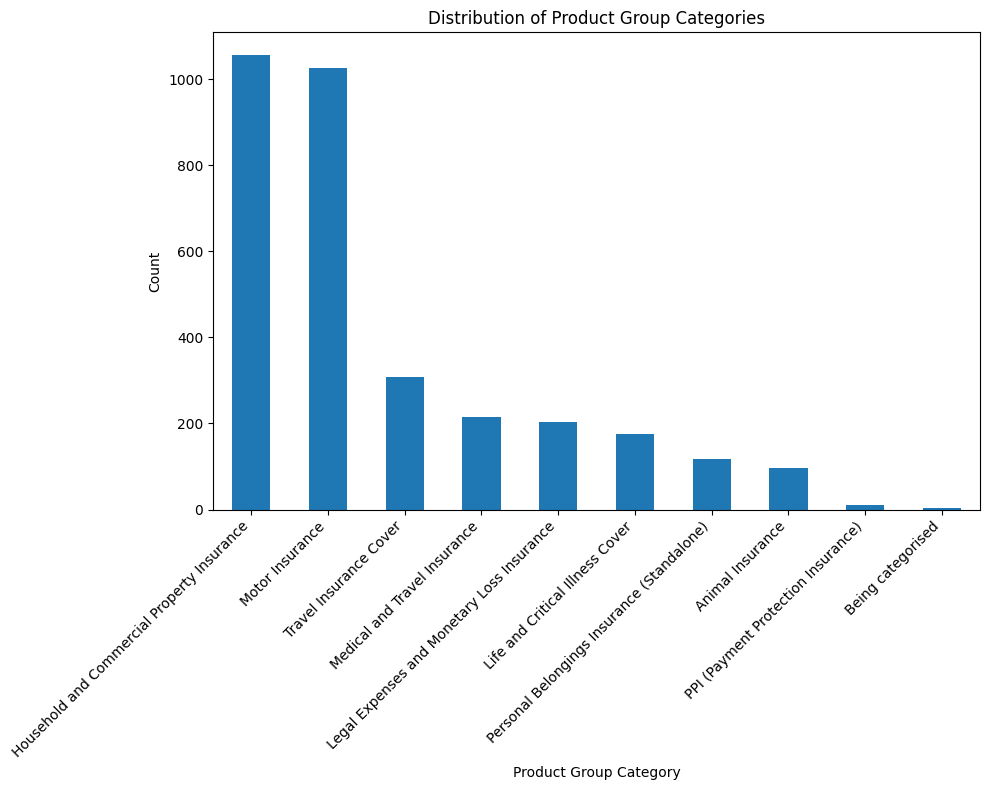

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the count of each category
category_counts = combined_df_categories['The complaint_most_common_group_name'].value_counts()

# Distribution of Product Group Categories
plt.figure(figsize=(10, 8))  
category_counts.plot(kind='bar')  
plt.title('Distribution of Product Group Categories')  
plt.xlabel('Product Group Category')  
plt.ylabel('Count')  
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  

#plt.savefig("Distribution of Product Group Categories.png")

plt.show()  

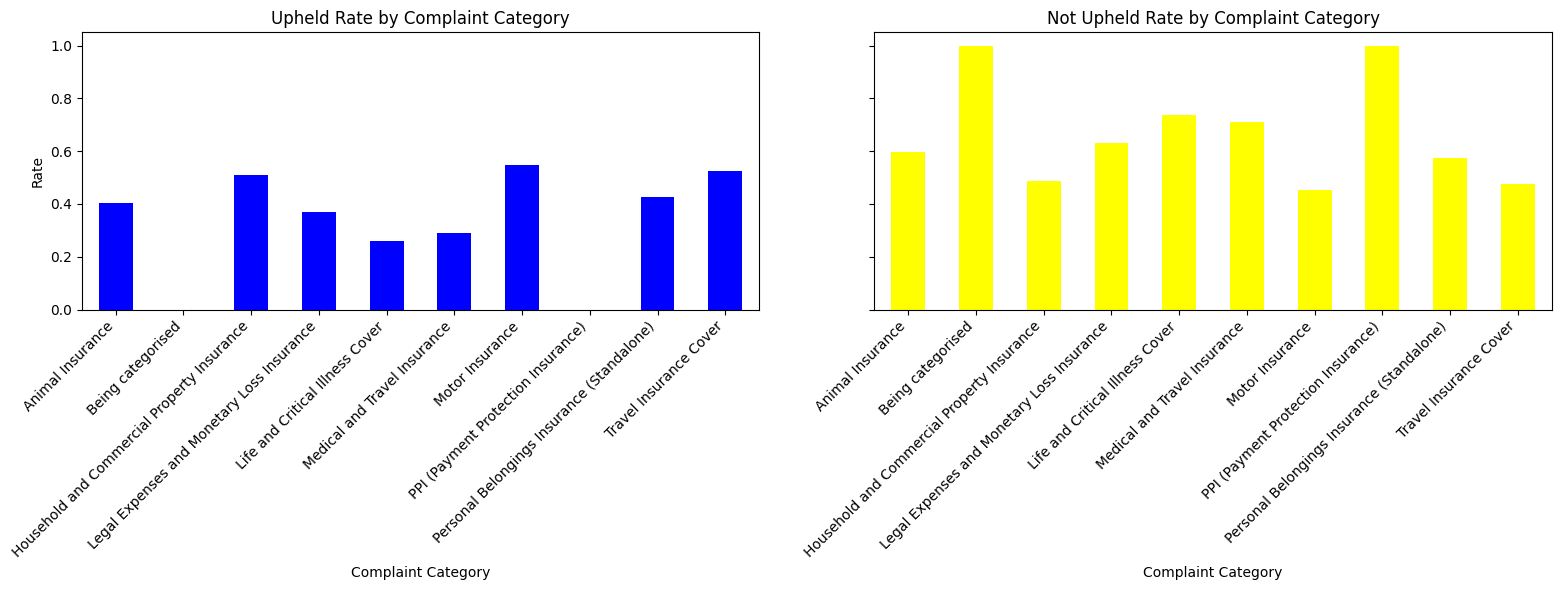

In [22]:
# Calculate the uphold and not uphold rates for each category
upheld_counts = final_df[final_df['decision'] == 'Upheld']['The complaint_most_common_group_name'].value_counts()
not_upheld_counts = final_df[final_df['decision'] != 'Upheld']['The complaint_most_common_group_name'].value_counts()
total_counts = final_df['The complaint_most_common_group_name'].value_counts()

upheld_rate = upheld_counts / total_counts
not_upheld_rate = not_upheld_counts / total_counts

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Upheld Rate
upheld_rate.plot(kind='bar', ax=ax[0], color='blue')
ax[0].set_title('Upheld Rate by Complaint Category')
ax[0].set_xlabel('Complaint Category')
ax[0].set_ylabel('Rate')
ax[0].set_xticklabels(upheld_rate.index, rotation=45, ha='right')

# Not Upheld Rate
not_upheld_rate.plot(kind='bar', ax=ax[1], color='yellow')
ax[1].set_title('Not Upheld Rate by Complaint Category')
ax[1].set_xlabel('Complaint Category')
ax[1].set_xticklabels(not_upheld_rate.index, rotation=45, ha='right')

plt.tight_layout()
#plt.savefig("Uphold(not) of Product Group Categories.png")
plt.show()

In [24]:
# Extract month information
final_df['date'] = pd.to_datetime(final_df['date'])
final_df['month'] = final_df['date'].dt.to_period('M')

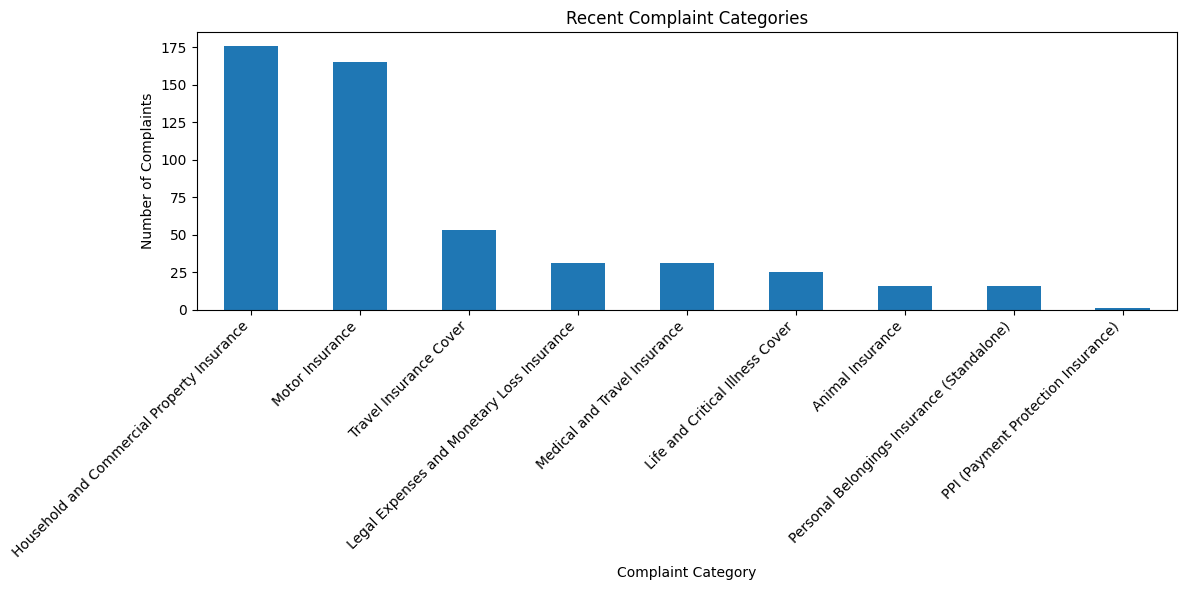

In [25]:
recent_period = pd.Timestamp.now() - pd.DateOffset(months=3)
recent_complaints = final_df[final_df['date'] > recent_period]

# Statistics on recent complaint categories
recent_categories = recent_complaints['The complaint_most_common_group_name'].value_counts()

plt.figure(figsize=(12, 6))
recent_categories.plot(kind='bar')
plt.title('Recent Complaint Categories')
plt.xlabel('Complaint Category')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#plt.savefig("Recent Complaint Categories of Product Group Categories.png")

plt.show()


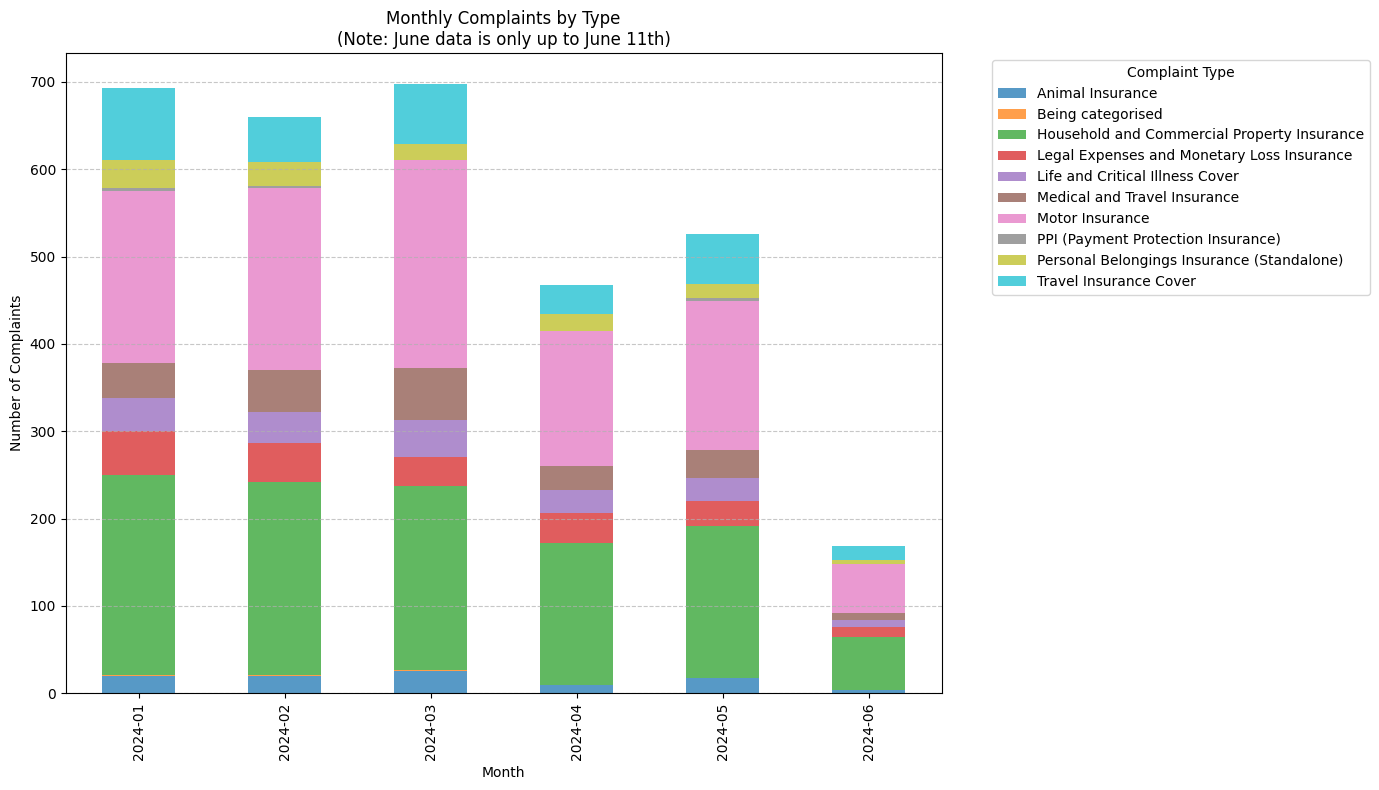

In [26]:
# Statistics on the number of complaints per category per month
monthly_complaints = final_df.groupby(['month', 'The complaint_most_common_group_name']).size().unstack(fill_value=0)

# Drawing Stacked Bar Graphs
monthly_complaints.plot(kind='bar', stacked=True, figsize=(14, 8), alpha=0.75)
plt.title('Monthly Complaints by Type\n(Note: June data is only up to June 11th)')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.legend(title='Complaint Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#plt.savefig("Monthly Complaints by Product Group Categories.png")

plt.show()

**“Please note that the June data only includes complaints recorded up to 11th June and therefore does not represent the complete data for the whole month of June. This may result in a low number of complaints in June. Readers should take this limitation into account when interpreting this data.”**

In [27]:
# Calculate the total number of complaints for each month
monthly_totals = final_df.groupby('month').size()
monthly_growth_rate = monthly_totals.pct_change() * 100 # Monthly growth rate

# Filter the results to keep only the data from January to May 2024
monthly_growth_rate = monthly_growth_rate.loc['2024-01':'2024-05']
print("Monthly Growth Rate (%):")
print(monthly_growth_rate)

# Monthly growth rate per category
monthly_complaints = final_df.groupby(['month', 'The complaint_most_common_group_name']).size().unstack(fill_value=0)
monthly_growth_rate_per_category = monthly_complaints.pct_change() * 100
monthly_growth_rate_per_category = monthly_growth_rate_per_category.loc['2024-01':'2024-05']

Monthly Growth Rate (%):
month
2024-01          NaN
2024-02    -4.761905
2024-03     5.757576
2024-04   -33.094556
2024-05    12.633833
Freq: M, dtype: float64


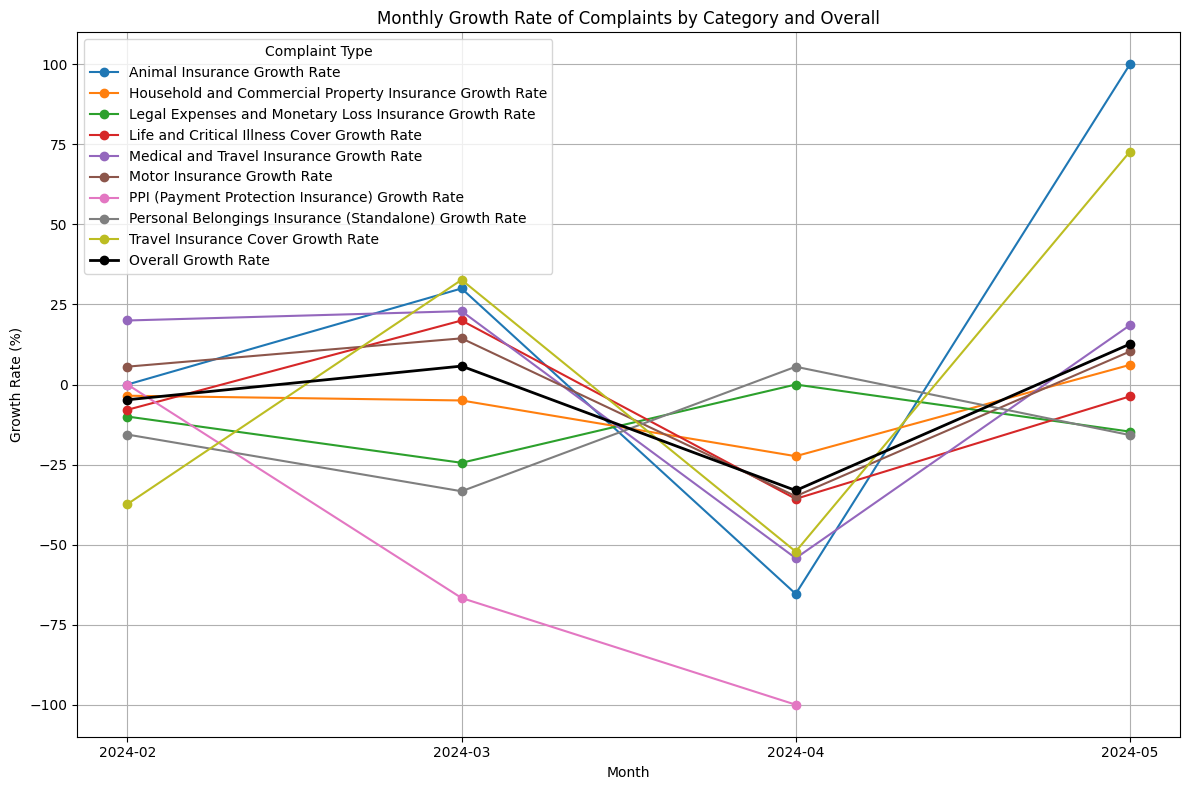

In [28]:
plt.figure(figsize=(12, 8))
if 'Being categorised' in monthly_growth_rate_per_category.columns:
    monthly_growth_rate_per_category = monthly_growth_rate_per_category.drop(columns=['Being categorised'])


# Monthly growth rates for each category
for category in monthly_growth_rate_per_category.columns:
    plt.plot(monthly_growth_rate_per_category.index.astype(str), 
             monthly_growth_rate_per_category[category], 
             marker='o', linestyle='-', label=f'{category} Growth Rate')

# Overall growth rates
plt.plot(monthly_growth_rate.index.astype(str), monthly_growth_rate, 
         marker='o', linestyle='-', color='black', label='Overall Growth Rate', linewidth=2)

plt.title('Monthly Growth Rate of Complaints by Category and Overall')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.legend(title='Complaint Type')
plt.tight_layout()
plt.show()

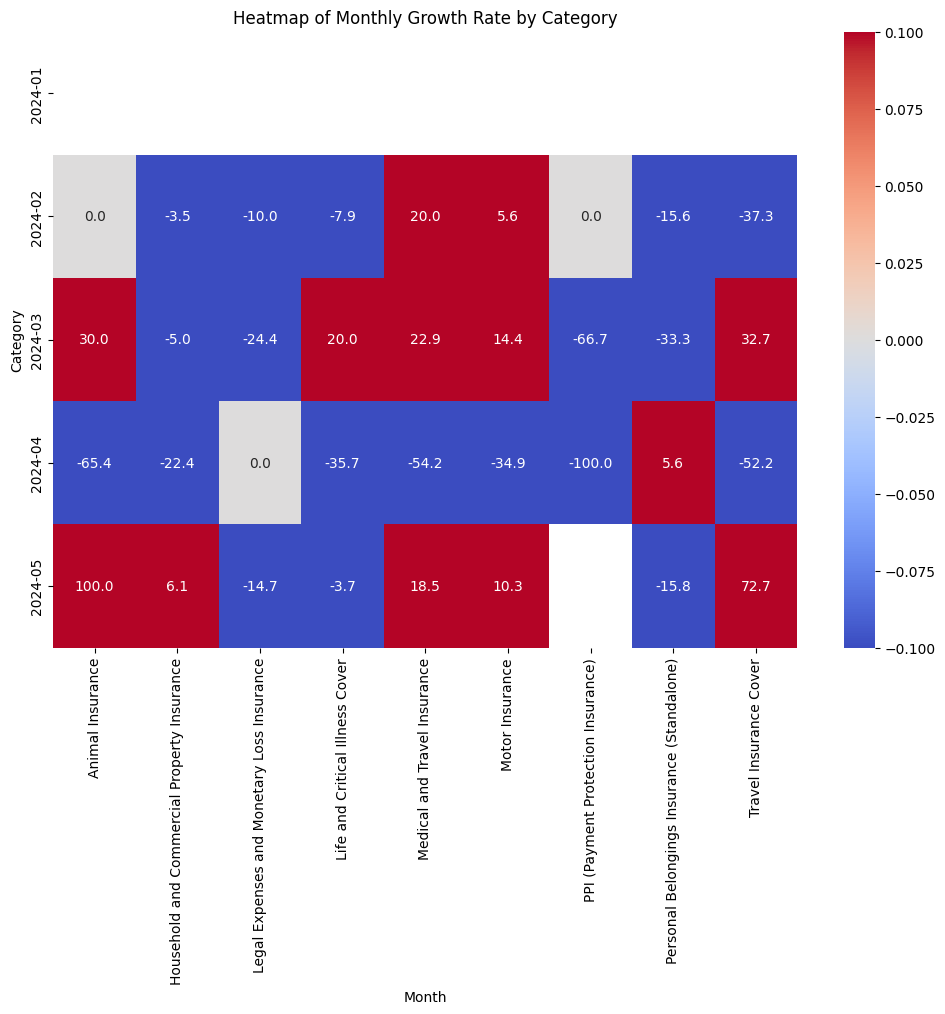

In [29]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(monthly_growth_rate_per_category, annot=True, cmap='coolwarm', fmt=".1f")

plt.title('Heatmap of Monthly Growth Rate by Category')
plt.xlabel('Month')
plt.ylabel('Category')
plt.show()

**Text Preprocessing with spaCy**

In [30]:
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.matcher import PhraseMatcher

In [31]:
nlp = spacy.load('en_core_web_sm')

# Define a list of custom stop words
custom_stop_words = ['mr', 'mrs', 'ms', 'miss', 'complaint', 'policy', 'insurance', 
                     'investigator', 'happen', 'decision', 'say', 'think', 'happen', 
                     'provide', 'consider', 'tell', 'explain', 'accept', 'include', 
                     'receive', 'decide', 'need', 'refer', 'not', 'take', 'bring', 
                     'cover', 'uphold', 'ask']

# Add the custom stop words to the spaCy stop words set.
for word in custom_stop_words:
    nlp.vocab[word].is_stop = True

def preprocess_with_spacy(text):
    """
    Preprocesses the input text by cleaning and tokenizing it using spaCy.
    Returns A tuple containing the list of processed tokens, the cleaned text, and the doc object.
    """
    # Remove HTML tags.
    text = re.sub(r'<.*?>', '', text)
    
    # Process contractions and remove non-alphabet characters, except spaces.
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'", "", text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    
    # Remove excessive whitespace.
    cleaned_text = re.sub(r'\s+', ' ', text).strip()
    
    # Process the cleaned text with spaCy.
    doc = nlp(cleaned_text.lower())
    
    # Remove stop words and punctuation, and perform lemmatization.
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    return tokens, cleaned_text, doc

**Keyword extraction based on TF-IDF**

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

In [33]:
def extract_subject_verb_object_pairs(doc):
    '''
    Identifies patterns where a subject and verb are directly related, and an object is associated with the verb. 
    '''
    svos = []
    for token in doc:
        if token.dep_ in ("nsubj", "nsubjpass") and token.head.pos_ == "VERB":
            subject = token.text
            verb = token.head.text
            for child in token.head.children:
                if child.dep_ in ("dobj", "attr", "prep"):
                    svos.append((subject, verb, child.text))
    return svos

def extract_keywords(tokens, vectorizer, top_n=70):
    '''
    Extracts top N keywords from a list of tokens using TF-IDF.
    '''
    try:
        if not tokens:
            raise ValueError("Empty token list")
        # Calculate TF-IDF matrix from the tokens
        X = vectorizer.fit_transform([' '.join(tokens)])
        feature_array = np.array(vectorizer.get_feature_names_out())
        tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]
        top_n_keywords = feature_array[tfidf_sorting][:top_n]
        top_n_tfidf_values = X.toarray()[0, tfidf_sorting][:top_n]
        return top_n_keywords, top_n_tfidf_values  # Return keywords and numeric features
    except ValueError as e:
        print(f"Error extracting keywords: {e}")
        return [], []

# Extracts verbs (action phrases)   
def extract_action_phrases(doc):
    actions = []
    for token in doc:
        if token.pos_ == "VERB":
            actions.append(token.text)
    return actions

# Test example
text = """Mr C’s policy was taken out on 18 June 1974 through Provident Life. He says that both 
himself and his wife took out whole of life policies at the same time for funeral costs and 
expenses for their surviving partner and family. Mr C says they were set up on a with profits 
basis. Mr C’s policy had a £6,000 sum assured and a £6.10 monthly premium, with an 
additional 26p supplement for mortgage cover. Premiums were payable up to 2011 – when 
Mr C would turn 65. However, the policy was made “paid up” after Mr C ceased paying the 
policy premiums from 18 October 1981."""


tokens, cleaned_text, doc = preprocess_with_spacy(text)
for word in custom_stop_words:
    nlp.vocab[word].is_stop = True

# Define and prepare the TF-IDF vectorizer with custom stop words
vectorizer = TfidfVectorizer(stop_words=custom_stop_words)

svos = extract_subject_verb_object_pairs(doc)
print("SVOs:", svos)

keywords = extract_keywords(tokens, vectorizer)
print("Keywords:", keywords)

actions = extract_action_phrases(doc)
print("Actions:", actions)

SVOs: [('policy', 'taken', 'on'), ('policy', 'taken', 'through'), ('himself', 'took', 'whole'), ('himself', 'took', 'at'), ('they', 'set', 'on'), ('they', 'set', 'with'), ('policy', 'had', 'sum')]
Keywords: (array(['premium', 'life', 'pay', 'cs', 'time', 'sum', 'supplement', 'set',
       'survive', 'turn', 'wife', 'payable', 'profit', 'provident',
       'october', 'mortgage', 'monthly', 'june', 'partner', 'funeral',
       'family', 'expense', 'cost', 'cease', 'basis', 'assure',
       'additional'], dtype=object), array([0.45226702, 0.30151134, 0.30151134, 0.30151134, 0.15075567,
       0.15075567, 0.15075567, 0.15075567, 0.15075567, 0.15075567,
       0.15075567, 0.15075567, 0.15075567, 0.15075567, 0.15075567,
       0.15075567, 0.15075567, 0.15075567, 0.15075567, 0.15075567,
       0.15075567, 0.15075567, 0.15075567, 0.15075567, 0.15075567,
       0.15075567, 0.15075567]))
Actions: ['taken', 'says', 'took', 'surviving', 'says', 'set', 'had', 'assured', 'turn', 'made', 'paid', 'cea

In [34]:
def process_texts_in_batches_actions(txt_dir, sections_to_process, vectorizer, batch_size=100, max_words=200):
    '''
    Processes text files in batches, extracts specified sections, truncates text to a specified number of words,
    computes keywords and their TF-IDF values, and compiles the results
    '''
    all_files = [os.path.join(txt_dir, file) for file in os.listdir(txt_dir) if file.endswith('.txt')]
    total_files = len(all_files)
    processed_data = []

    for i in range(0, total_files, batch_size):
        batch_files = all_files[i:i + batch_size]
        for txt_file in batch_files:
            with open(txt_file, "r", encoding="utf-8") as f:
                text = f.read()
            sections = split_text_into_sections(text) 
            # Process only the relevant sections
            processed_sections = {}
            for section, content in sections.items():
                if section in sections_to_process:
                    tokens, cleaned_text, doc = preprocess_with_spacy(content)
                    # Truncate tokens to the specified maximum number
                    tokens = tokens[:max_words]
                    if not tokens:
                        print(f"Warning: No valid tokens found in file {txt_file} after truncation.")
                        continue

                    keywords, tfidf_values = extract_keywords(tokens, vectorizer)
                    processed_sections[f"{section}_keywords"] = keywords  # Save keywords for word clouds
                    processed_sections[f"{section}_tfidf_values"] = tfidf_values  # Save numerical features for modelling

            processed_data.append({"file_name": os.path.basename(txt_file), **processed_sections})

    df = pd.DataFrame(processed_data)
    return df


In [35]:
txt_dir = "/kaggle/input/texts-1-6-all/texts_1_6_all"  
sections_to_process = ["What happened"]  
# Batch processing
df_all = process_texts_in_batches_actions(txt_dir, sections_to_process, vectorizer)
print(df_all.head())

Error extracting keywords: empty vocabulary; perhaps the documents only contain stop words
         file_name                             What happened_keywords  \
0  DRN-4761450.txt  [claim, chubb, phone, european, decline, europ...   
1  DRN-4597052.txt  [central, st, quote, comparison, website, decl...   
2  DRN-4627652.txt  [dog, pinnacle, claim, tooth, treatment, pay, ...   
3  DRN-4665697.txt                                                 []   
4  DRN-4569181.txt  [admiral, engineer, repair, charge, visit, evi...   

                          What happened_tfidf_values  
0  [0.6227991553292184, 0.3892494720807615, 0.233...  
1  [0.567774973957669, 0.567774973957669, 0.20277...  
2  [0.5975309495786169, 0.33611115913797196, 0.33...  
3                                                 []  
4  [0.5819143739626463, 0.363696483726654, 0.2909...  


In [36]:
# Descriptive statistical information
print(df_all.info())
print(df_all.describe())
print(df_all.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   file_name                   3212 non-null   object
 1   What happened_keywords      3210 non-null   object
 2   What happened_tfidf_values  3210 non-null   object
dtypes: object(3)
memory usage: 75.4+ KB
None
              file_name                             What happened_keywords  \
count              3212                                               3210   
unique             3212                                               3210   
top     DRN-4594517.txt  [claim, amtrust, building, contractor, firm, p...   
freq                  1                                                  1   

                               What happened_tfidf_values  
count                                                3210  
unique                                               3210

In [37]:
# Converting Keyword Fields to Lists
def ensure_list_format(value):
    if isinstance(value, list):
        return value
    # Handle missing values represented as NaN by returning an empty list
    elif isinstance(value, float) and np.isnan(value):
        return []
    elif isinstance(value, str):
        return [value]
    else:
        return [value]

df_keywords_list = df_all.copy()
df_keywords_list['What happened_keywords'] = df_keywords_list['What happened_keywords'].apply(ensure_list_format)

print(df_keywords_list['What happened_keywords'].apply(type).value_counts())

What happened_keywords
<class 'list'>    3212
Name: count, dtype: int64


In [38]:
merged_df = pd.merge(df_keywords_list, combined_df_categories, on='file_name')

category_keywords = {}

for _, row in merged_df.iterrows():
    category = row['The complaint_most_common_group_name']
    keywords = row['What happened_keywords']

    if category not in category_keywords:
        category_keywords[category] = []
    # Ensure that the keywords are stored as a list; if so, extend the list for the category
    if isinstance(keywords, list):
        category_keywords[category].extend(keywords)
    else:
        print(f"Warning: Keywords for file {row['file_name']} is not a list.")

In [39]:
# Ensure all elements in a list are pure Python lists, not numpy arrays
def ensure_python_list_and_flatten(lst):
    flattened_list = []
    for elem in lst:
        if isinstance(elem, list):  
            flattened_list.extend(elem)
        elif isinstance(elem, np.ndarray):  
            flattened_list.extend(elem.tolist())
        else:
            flattened_list.append(elem)
    return flattened_list

# Check and process keywords for each category
for category in category_keywords.keys():
    category_keywords[category] = ensure_python_list_and_flatten(category_keywords[category])

# Calculate keyword frequency per category
category_keyword_freq = {category: Counter(keywords) for category, keywords in category_keywords.items()}


In [40]:
# Top 10 keywords for each category
for category, freq in category_keyword_freq.items():
    print(f"Category: {category}")
    print("Top 20 Keywords:", freq.most_common(10))
    print("\n")

Category: Personal Belongings Insurance (Standalone)
Top 20 Keywords: [('claim', 95), ('agree', 67), ('service', 67), ('pay', 63), ('unhappy', 58), ('phone', 54), ('complain', 52), ('contact', 45), ('term', 45), ('repair', 45)]


Category: Motor Insurance
Top 20 Keywords: [('claim', 793), ('car', 738), ('pay', 607), ('service', 582), ('agree', 557), ('complain', 539), ('compensation', 457), ('damage', 426), ('offer', 407), ('final', 405)]


Category: Animal Insurance
Top 20 Keywords: [('claim', 93), ('vet', 71), ('condition', 66), ('pet', 65), ('treatment', 62), ('dog', 56), ('cost', 50), ('decline', 49), ('pay', 47), ('service', 47)]


Category: Household and Commercial Property Insurance
Top 20 Keywords: [('claim', 935), ('damage', 716), ('service', 629), ('cause', 609), ('agree', 548), ('property', 533), ('home', 481), ('complain', 476), ('pay', 475), ('repair', 466)]


Category: Travel Insurance Cover
Top 20 Keywords: [('claim', 261), ('travel', 207), ('pay', 159), ('service', 156)

In [ ]:
!pip install wordcloud

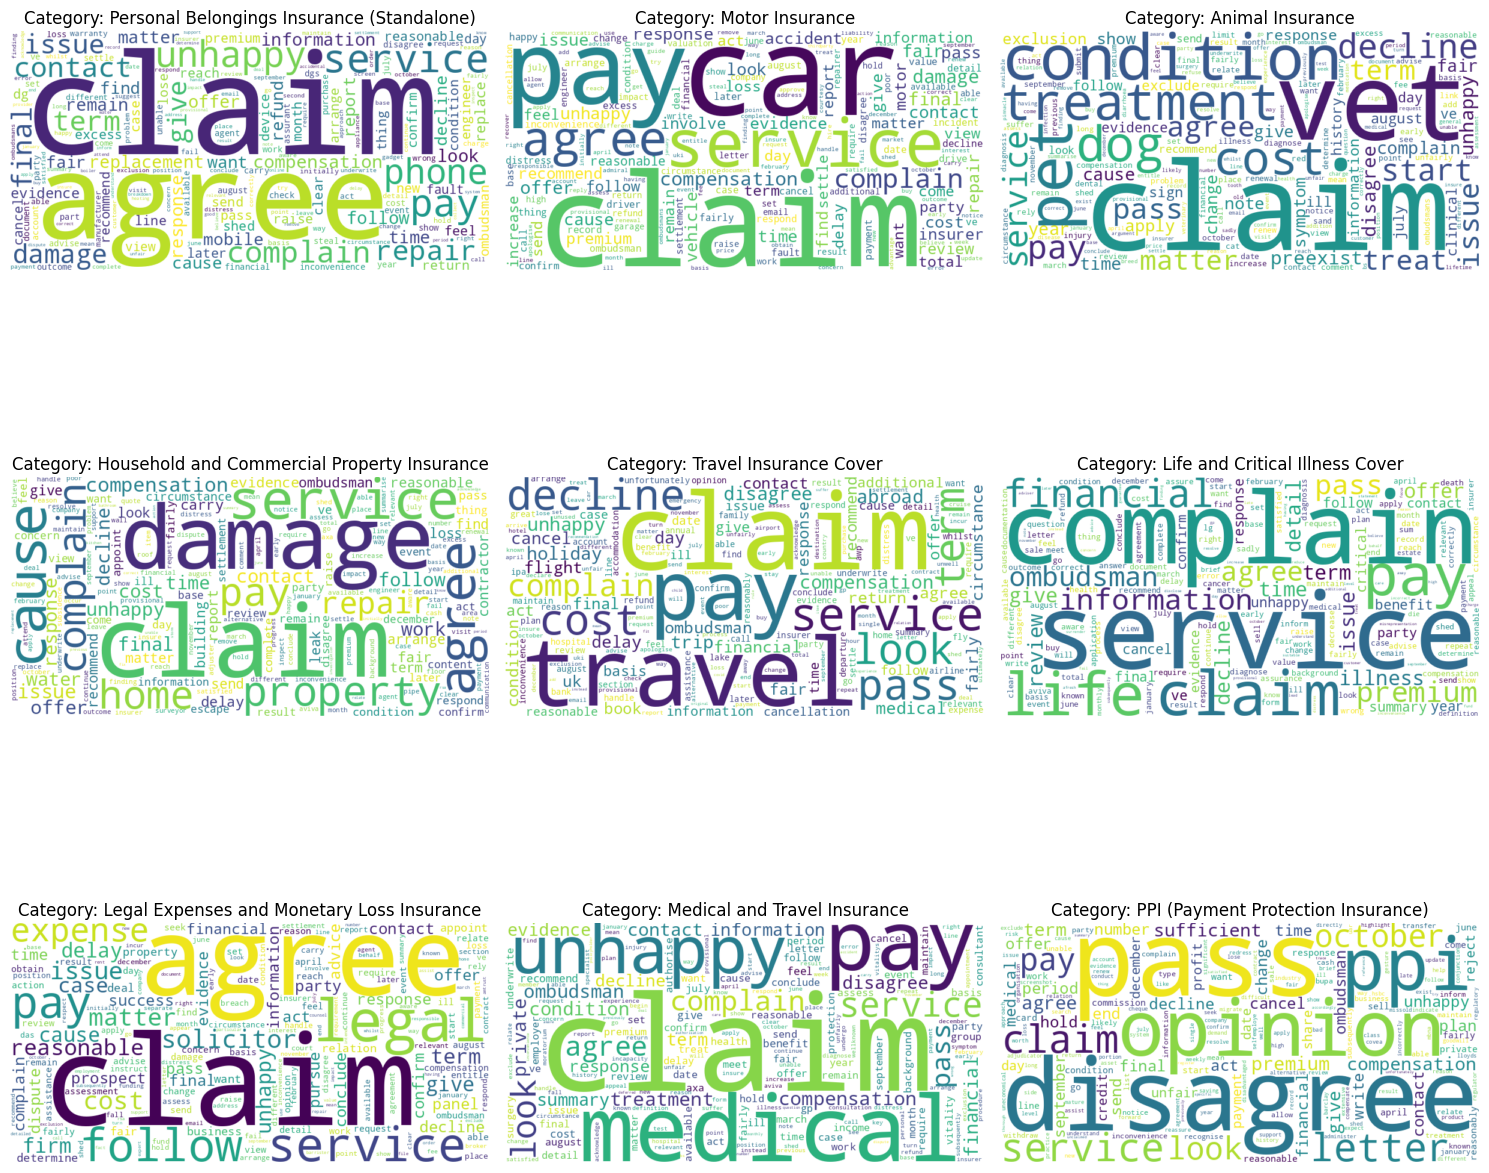

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

excluded_category = 'Being categorised'
filtered_categories = {k: v for k, v in category_keyword_freq.items() if k != excluded_category}

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over each category to generate word clouds and plot them in subgraphs
for ax, (category, freq) in zip(axs.flatten(), filtered_categories.items()):
    # Creating word cloud Instance
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Category: {category}')
    ax.axis('off')
    
plt.tight_layout(h_pad=1.0)  

#plt.savefig("wordclouds_group.png")
plt.show()

**Binary classification projections**

**1. Properties and characteristics of data**
* Text data: mainly the original text content of the complaint (high-frequency keywords proposed by TF-IDF), the dimension of text data is usually high, and there may be strong correlation between features.
* Category features: such as product category, company name, etc., which are discrete features.
* Target variable: the adjudication result is binary (Upheld or Not Upheld)

**2. Key Factors for Model Selection**
* Interpretability: Businesses and regulators need to understand how models make decisions.
* Accuracy: the predictive accuracy of models needs to be as high as possible in order to accurately identify complaints that are likely to be upheld.
* Computational cost: the speed of model training and prediction also needs to be considered when dealing with large-scale data.

**3. Some alternative models**
If the company is highly focused on the transparency and interpretability of the model and the data size is moderate, then logistic regression may be more appropriate; if high accuracy prediction is required and high computational cost is acceptable, then gradient boosting tree (e.g. XGBoost) may be the best choice.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [45]:
df_all['file_id'] = df_all['file_name'].apply(lambda x: x.replace('.txt', ''))
df_merged_predict = df_all.merge(final_df, left_on='file_id', right_on='decision_id', how='inner')
df_merged_predict = df_merged_predict.drop(['file_id','The complaint_top_match','date','decision_id','month','company'], axis=1)

print(df_merged_predict.head())

         file_name                             What happened_keywords  \
0  DRN-4761450.txt  [claim, chubb, phone, european, decline, europ...   
1  DRN-4597052.txt  [central, st, quote, comparison, website, decl...   
2  DRN-4627652.txt  [dog, pinnacle, claim, tooth, treatment, pay, ...   
3  DRN-4665697.txt                                                 []   
4  DRN-4569181.txt  [admiral, engineer, repair, charge, visit, evi...   

                          What happened_tfidf_values  \
0  [0.6227991553292184, 0.3892494720807615, 0.233...   
1  [0.567774973957669, 0.567774973957669, 0.20277...   
2  [0.5975309495786169, 0.33611115913797196, 0.33...   
3                                                 []   
4  [0.5819143739626463, 0.363696483726654, 0.2909...   

          The complaint_most_common_group_name    decision  
0   Personal Belongings Insurance (Standalone)      Upheld  
1                              Motor Insurance  Not upheld  
2                             Animal Insu

In [46]:
df_merged_predict = df_merged_predict[df_merged_predict['What happened_keywords'].apply(lambda x: not (isinstance(x, list) and len(x) == 0))]
df_merged_predict['What happened_keywords'] = df_merged_predict['What happened_keywords'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
print(df_merged_predict['What happened_keywords'].apply(type).value_counts())

What happened_keywords
<class 'list'>     3209
<class 'float'>       2
Name: count, dtype: int64


In [47]:
tfidf_values = df_merged_predict['What happened_tfidf_values']
df_merged_predict = df_merged_predict[df_merged_predict['What happened_tfidf_values'].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) > 0)]

processed_tfidf_values = []
max_length = 60 

for values in df_merged_predict['What happened_tfidf_values']:
    if len(values) < max_length:
        # Padding / truncating to maximum length
        values = np.pad(values, (0, max_length - len(values)), 'constant')
    elif len(values) > max_length:
        values = values[:max_length]
    processed_tfidf_values.append(values)

X_tfidf_logis = np.array(processed_tfidf_values)

print(X_tfidf_logis.shape)
print(f"TF-IDF features dtype: {X_tfidf_logis.dtype}")

(3209, 60)
TF-IDF features dtype: float64


In [48]:
# Initialize the OneHotEncoder to convert categorical data into one-hot encoded numeric arrays
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
one_hot_category = encoder.fit_transform(df_merged_predict[['The complaint_most_common_group_name']])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [49]:
# Combine the TF-IDF feature matrix (X_tfidf_logis) with the one-hot encoded categorical features
X_logis_2 = np.hstack((X_tfidf_logis, one_hot_category))

print(X_logis_2.shape)
print(f"Combined features dtype: {X_logis_2.dtype}")

(3209, 70)
Combined features dtype: float64


In [50]:
# Convert the 'decision' into binary labels suitable for logistic regression
y_logis = df_merged_predict['decision'].apply(lambda x: 1 if x == 'Upheld' else 0)

In [51]:
stratify_labels = df_merged_predict['The complaint_most_common_group_name'] + '_' + df_merged_predict['decision'].astype(str)

# Conduct multi-stage stratified sampling
X_train_logistics, X_test_logistics, y_train_logistics, y_test_logistics = train_test_split(
    X_logis_2, y_logis, test_size=0.2, random_state=42, stratify=stratify_labels )
print(X_train_logistics.shape, X_test_logistics.shape)
print(y_train_logistics.shape, y_test_logistics.shape)

(2567, 70) (642, 70)
(2567,) (642,)


In [52]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_logistics, y_train_logistics)

y_pred_logistics = logreg.predict(X_test_logistics)
print("Accuracy:", accuracy_score(y_test_logistics, y_pred_logistics))
print("Classification Report:\n", classification_report(y_test_logistics, y_pred_logistics))

Accuracy: 0.5950155763239875
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.55      0.59       335
           1       0.57      0.64      0.60       307

    accuracy                           0.60       642
   macro avg       0.60      0.60      0.59       642
weighted avg       0.60      0.60      0.59       642



* The original dataset was split into training and test sets using train_test_split in the ratio of 80% and 20% and stratified sampling was ensured.
* Perform a 50-50 cross-validation using GridSearchCV on the training set.
* Model evaluation on test set

**LR with GridSearch**

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Split the data into training set (80%) and test set (20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X_logis_2, y_logis, test_size=0.2, random_state=42, stratify=stratify_labels
)

# Further stratifying the training set for cross-validation
df_train_temp = df_merged_predict.loc[y_train_temp.index]

stratify_labels_train = df_train_temp['The complaint_most_common_group_name'] + '_' + df_train_temp['decision'].astype(str)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=42, stratify=stratify_labels_train
)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



(1925, 70) (642, 70) (642, 70)
(1925,) (642,) (642,)


In [54]:
logistic_model = LogisticRegression(solver='liblinear', random_state=42)
param_grid = {'C': [0.1, 1, 10, 100, 150]} # Defining the parameter grid

# Five-fold Cross-Validation Tuning with GridSearchCV
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)


grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Retrain the model on the training and validation sets using the optimal parameters
best_logistic_model = grid_search.best_estimator_
best_logistic_model.fit(X_train, y_train)

y_val_pred = best_logistic_model.predict(X_val)
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

y_test_pred = best_logistic_model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'C': 10}
Best cross-validation score:  0.6062337662337662
Validation Accuracy:  0.6105919003115264
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.61      0.62       336
           1       0.59      0.61      0.60       306

    accuracy                           0.61       642
   macro avg       0.61      0.61      0.61       642
weighted avg       0.61      0.61      0.61       642

Test Accuracy:  0.5716510903426791
Test Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.54      0.57       335
           1       0.55      0.61      0.57       307

    accuracy                           0.57       642
   macro avg       0.57      0.57      0.57       642
weighted avg       0.57      0.57      0.57       642



**SVM**

In [55]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Feature standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_logistics)
X_test_scaled = scaler.transform(X_test_logistics)

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Training and evaluating SVM models
svm_model.fit(X_train_scaled, y_train_logistics)
y_pred_svm = svm_model.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test_logistics, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test_logistics, y_pred_svm))


SVM Accuracy: 0.5965732087227414
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.58      0.60       335
           1       0.57      0.62      0.59       307

    accuracy                           0.60       642
   macro avg       0.60      0.60      0.60       642
weighted avg       0.60      0.60      0.60       642



In [56]:
# Five-fold Cross-Validation Tuning with GridSearchCV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_temp)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.5, 1, 2],  # Regularisation parameters
    'gamma': ['scale', 'auto', 0.01, 0.1],  # Kernel function coefficients
    'kernel': ['linear', 'rbf', 'sigmoid']  # Kernel function type
}


svm_model = SVC(random_state=42)
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train_scaled, y_train_temp)

print("Best SVM parameters found: ", grid_search_svm.best_params_)
print("Best SVM Cross-validation Score: ", grid_search_svm.best_score_)

best_svm_model = grid_search_svm.best_estimator_
best_svm_model.fit(X_train_scaled, y_train_temp)

y_pred_svm = best_svm_model.predict(X_test_scaled)

print("Test SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Test SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best SVM parameters found:  {'C': 2, 'gamma': 0.01, 'kernel': 'rbf'}
Best SVM Cross-validation Score:  0.6275703309289219
Test SVM Accuracy: 0.6012461059190031
Test SVM Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.56      0.60       335
           1       0.57      0.64      0.61       307

    accuracy                           0.60       642
   macro avg       0.60      0.60      0.60       642
weighted avg       0.60      0.60      0.60       642



In [57]:
from sklearn.ensemble import GradientBoostingClassifier
# Create and train a GBDT model
gbdt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
gbdt_model.fit(X_train_logistics, y_train_logistics)

y_pred_gbdt = gbdt_model.predict(X_test_logistics)

print("GBDT Accuracy:", accuracy_score(y_test_logistics, y_pred_gbdt))
print("GBDT Classification Report:\n", classification_report(y_test_logistics, y_pred_gbdt))


GBDT Accuracy: 0.5934579439252337
GBDT Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.60      0.61       335
           1       0.57      0.59      0.58       307

    accuracy                           0.59       642
   macro avg       0.59      0.59      0.59       642
weighted avg       0.59      0.59      0.59       642



In [58]:
param_grid = {
    'n_estimators': [75, 100, 150],  # Number of boosting stages to perform
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'max_depth': [3, 4, 5],  # Maximum depth of the individual regression estimators
    #'min_samples_split': [2, 5, 10],  # 内部节点再划分所需最小样本数
    #'min_samples_leaf': [1, 2, 4],  # 叶子节点最小样本数
    'subsample': [0.8, 0.9, 1.0]  # # Fraction of samples to be used for fitting individual base learners
}


gbdt_model = GradientBoostingClassifier(random_state=42)
# Five-Fold Cross-Validation Tuning with GridSearchCV
grid_search_gbdt = GridSearchCV(estimator=gbdt_model, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

grid_search_gbdt.fit(X_train_scaled, y_train_temp)
print("Best GBDT parameters found: ", grid_search_gbdt.best_params_)
print("Best GBDT F1 Score: ", grid_search_gbdt.best_score_)

best_gbdt_model = grid_search_gbdt.best_estimator_
best_gbdt_model.fit(X_train_scaled, y_train_temp)

y_pred_gbdt = best_gbdt_model.predict(X_test_scaled)

print("Test GBDT Accuracy:", accuracy_score(y_test, y_pred_gbdt))
print("Test GBDT Classification Report:\n", classification_report(y_test, y_pred_gbdt))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   1.1s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .................C=0.5, gamma=scale, kernel=sigmoid; total time=   0.6s
[CV] END ...................C=0.5, gamma=auto, kernel=linear; total time=   1.1s
[CV] END ......................C=0.5, gamma=auto, kernel=rbf; total time=   0.6s
[CV] END ......................C=0.5, gamma=auto, kernel=rbf; total time=   0.7s
[CV] END ..................C=0.5, gamma=auto, kernel=sigmoid; total time=   0.6s
[CV] END ...................C=0.5, gamma=0.01, kernel=linear; total time=   1.2s
[CV] END ......................C=0.5, gamma=0.01, kernel=rbf; total time=   0.6s
[CV] END ..................C=0.5, gamma=0.01, kernel=sigmoid; total time=   0.6s
[CV] END ....................C=0.5, gamma=0.1,